# Sensitibity Analysis

We are going to use only three variables $I,\, P$ and $E$, each of them is a valid boolean string such that together they form a valid scenario (taking into account no more than 2 ones in each variable).

In [1]:
import numpy as np
import itertools
import pandas as pd
import warnings
import random

import datetime as dt
import time

import os
from os import listdir
from os.path import isfile,join
import matplotlib.pyplot as plt

In [2]:
PATH = '/home/moni/Documents/motmo/timeSeries_files/' # original data
PATH2 = '/home/moni/Documents/motmo/data_without_hhID/' # folder in which we will store transformed data

### Creating input space
- $I$ and $P$ are boolean arrays of size three so that they have no 2 consecutive ones.
- $E$ is a boolean array of size 4. 

In total, there are $7*7*11=539$ possible scenarios.

In [3]:
s3 = list(itertools.product(range(2), repeat=3))
s4 = list(itertools.product(range(2), repeat=4))
l1 = [i for i in s3 if sum(i)<3]
l2 = l1
l3 = [i for i in s4 if sum(i)<3]
L=[]
L.append(l1)
L.append(l2)
L.append(l3)
inputs = list(itertools.product(*L)) # here we have the 539 scenarios

In [4]:
s3

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [5]:
# step = 1/6
I = list(range(0,7,1))
I = [i/6 for i in I]
P = I
E = list(range(0,11,1))
E = [i/10 for i in E]
E

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [66]:
dict_I

{(0, 0, 0): 0.0,
 (0, 0, 1): 0.16666666666666666,
 (0, 1, 0): 0.3333333333333333,
 (0, 1, 1): 0.5,
 (1, 0, 0): 0.6666666666666666,
 (1, 0, 1): 0.8333333333333334,
 (1, 1, 0): 1.0}

In [6]:
dict_I = dict(zip(l1,I))
dict_P = dict_I
dict_E = dict(zip(l3,E))
dict_E

{(0, 0, 0, 0): 0.0,
 (0, 0, 0, 1): 0.1,
 (0, 0, 1, 0): 0.2,
 (0, 0, 1, 1): 0.3,
 (0, 1, 0, 0): 0.4,
 (0, 1, 0, 1): 0.5,
 (0, 1, 1, 0): 0.6,
 (1, 0, 0, 0): 0.7,
 (1, 0, 0, 1): 0.8,
 (1, 0, 1, 0): 0.9,
 (1, 1, 0, 0): 1.0}

In [7]:
inputs_d = []
k=0
for i in inputs:
    t = [dict_I[i[0]], dict_P[i[1]], dict_E[i[2]]]
    inputs_d.append(t)
inputs_d

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.1],
 [0.0, 0.0, 0.2],
 [0.0, 0.0, 0.3],
 [0.0, 0.0, 0.4],
 [0.0, 0.0, 0.5],
 [0.0, 0.0, 0.6],
 [0.0, 0.0, 0.7],
 [0.0, 0.0, 0.8],
 [0.0, 0.0, 0.9],
 [0.0, 0.0, 1.0],
 [0.0, 0.16666666666666666, 0.0],
 [0.0, 0.16666666666666666, 0.1],
 [0.0, 0.16666666666666666, 0.2],
 [0.0, 0.16666666666666666, 0.3],
 [0.0, 0.16666666666666666, 0.4],
 [0.0, 0.16666666666666666, 0.5],
 [0.0, 0.16666666666666666, 0.6],
 [0.0, 0.16666666666666666, 0.7],
 [0.0, 0.16666666666666666, 0.8],
 [0.0, 0.16666666666666666, 0.9],
 [0.0, 0.16666666666666666, 1.0],
 [0.0, 0.3333333333333333, 0.0],
 [0.0, 0.3333333333333333, 0.1],
 [0.0, 0.3333333333333333, 0.2],
 [0.0, 0.3333333333333333, 0.3],
 [0.0, 0.3333333333333333, 0.4],
 [0.0, 0.3333333333333333, 0.5],
 [0.0, 0.3333333333333333, 0.6],
 [0.0, 0.3333333333333333, 0.7],
 [0.0, 0.3333333333333333, 0.8],
 [0.0, 0.3333333333333333, 0.9],
 [0.0, 0.3333333333333333, 1.0],
 [0.0, 0.5, 0.0],
 [0.0, 0.5, 0.1],
 [0.0, 0.5, 0.2],
 [0.0, 0.5,

### Sampling
### Variance decomposition
We see this model as a function $f(X)=Y$, where the inputs are the scenarios, so $X\in\mathbb{R}^d$ and the output is a real value, that in our case, can be the emissions or the mobility choices. First, we are going to do an analysis on (overall) emissions and when we implement it, we can use the othe outputs.

The idea consists in estimating certain variances that we are going to define later in order to compute some sesitivity indices (there are first and second order sensitivity indices). We write
$$Var(Y)=\sum_{i=1}^dV_i+\sum_{i<j}^dV_{ij}+\ldots+V_{1,2, \ldots,d}$$where
$$V_i=Var_{x_i}(E_{X_{\sim i}}(Y|X))$$where the $X_{\sim i}$ notation means the set of all variables except $x_i$.

#### First Order Index
$$S_i= \frac{V_i}{Var(Y)}$$We can interpret it as follows: "the fractional reduction in the variance of $Y$ which would be obtained on average if $X$ could be fixed".


In [8]:
def sampling(in_space,N):
    AB = random.sample(in_space,2*N)
    A = AB[0:N]
    B = AB[N:2*N]
    return A,B

In [62]:
ABtest = random.sample(inputs_d,2*100)
Atest = ABtest[0:100]
Btest = ABtest[100:200]
# Atest
# ABtest = np.zeros((3,8,3))
# Ant,Bnt = np.array(Atest), np.array(Btest)
# ABtest[0] = Ant
# ABtest[0][:,0] = Bnt[:,0]
# ABtest[1]
# dict_I

In [39]:
def mat_AB_i(A,B): 
    d = 3
    N = len(A)
    An,Bn = np.array(A), np.array(B)
    AB_mat = np.zeros((d,N,d))
    for i in range(0,d):
        AB_mat[i] = An
        AB_mat[i][:,i] = Bn[:,i]
    return AB_mat

In [63]:
ABi = mat_AB_i(Atest,Btest)
#ABi

In [46]:
ABi.shape

(3, 100, 3)

In [64]:
Anp = np.array(Atest)
Bnp = np.array(Btest)
AB = np.append([Anp],[Bnp], axis=0)
AB = np.reshape(AB,(200,3))
ABi = np.reshape(ABi, (300,3))
sampleAB = np.append(AB,ABi,axis=0)
sampleAB.shape

(500, 3)

In [58]:
sampleAB

array([[0.66666667, 0.66666667, 0.5       ],
       [0.16666667, 0.33333333, 0.5       ],
       [0.16666667, 0.5       , 0.8       ],
       ...,
       [0.83333333, 0.33333333, 1.        ],
       [1.        , 0.5       , 0.6       ],
       [0.5       , 0.83333333, 0.7       ]])

In [65]:
len(np.unique(sampleAB,axis=0))

344

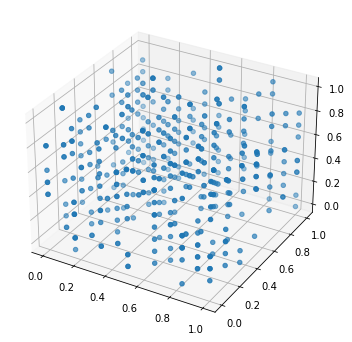

In [74]:
x = sampleAB[:,0]
y = sampleAB[:,1]
z = sampleAB[:,2]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
plt.savefig("MoTMo_sampling.png")

### Estimating
To compute the variance, we can use the following estimator: $$Var_{x_i}(E_{X_{\sim i}}(Y|X))\approx \frac{1}{N}\sum_{i=1}^Nf(B)_j\left(f(A_B^i)_j-f(A)_j\right)$$

First, get outputs and then compute the variance

In [14]:
te_df = pd.read_csv("total_emissions.csv") # global variable
te_df
# cond = (te_df['scenario'] == "CH0SP0SE0WE0BP1RE1CO1DI1WO0CS0")
# result = te_df[cond].total_emissions.values[0]
# result

,scenario,total_emissions
0,CH1SP0SE1WE0BP1RE0CO0DI0WO0CS0,2.243213e+12
1,CH1SP0SE1WE1BP1RE0CO1DI1WO0CS0,2.082187e+12
2,CH0SP1SE0WE0BP0RE1CO0DI0WO1CS0,2.224649e+12
3,CH1SP1SE0WE0BP1RE0CO0DI1WO1CS0,2.206465e+12
4,CH1SP0SE1WE0BP0RE1CO0DI1WO0CS1,2.198543e+12
...,...,...
534,CH0SP0SE0WE0BP1RE1CO0DI0WO1CS0,2.217200e+12
535,CH0SP0SE0WE0BP1RE1CO1DI1WO0CS0,2.164500e+12
536,CH0SP0SE1WE0BP1RE1CO1DI0WO1CS0,2.203569e+12
537,CH0SP0SE0WE1BP0RE0CO0DI1WO0CS0,2.094284e+12


In [15]:
def invert_dict(d_X):
    dI_X = {v: k for k, v in d_X.items()}
    return dI_X
d_I = invert_dict(dict_I)
d_P = invert_dict(dict_P)
d_E = invert_dict(dict_E)

In [16]:
d_I[0.5]

(0, 1, 1)

In [17]:
def from_dec_to_bool(row):
    rbool = [d_I[row[0]], d_P[row[1]], d_E[row[2]]]
    return rbool

In [30]:
from_dec_to_bool(ABi[0][0])

[(0, 0, 1), (0, 1, 0), (1, 0, 0, 0)]

In [27]:
# input is a list of tuples [(1,0,0),(0,1,0),(1,0,0,0)]
# output 'CH1SP0SE0WE0BP1RE0CO1DI0WO0CS0'
def get_scenario_string(boolean_scenario): 
    bool_sc = list(sum(boolean_scenario,())) # flatten list
    dict2_I = dict(zip(I,l1))
    dict2_P = dict_I
    dict2_E = dict(zip(E,l3))
    #dict_E
    list_events = ['CH','SP','SE','WE','BP','RE','CO','DI','WO','CS']
    # prefix = "timeSeries_"
    # sufix = ".csv"
    f_n = [l+str(s) for l,s in zip(list_events,bool_sc)]
    f_n = ''.join(f_n)
    file_name = f_n
    return file_name

In [70]:
ABi[0][0]

array([0.16666667, 0.33333333, 0.7       ])

In [28]:
get_scenario_string(from_dec_to_bool(ABi[0][0]))

'CH0SP0SE1WE0BP1RE0CO1DI0WO0CS0'

In [37]:
def get_output(M):#input is a matrix M, make sure it is a list
    out_vector = []
    n = len(M)
    for i in range(0,n):
        dec_row = M[i]
        row_bool = from_dec_to_bool(dec_row)
        string = get_scenario_string(row_bool)
        cond = (te_df['scenario'] == string)
        # print(cond)
        outp = te_df[cond].total_emissions.values[0]
        out_vector.append(outp)
    return out_vector

In [74]:
Atest

[[0.5, 0.3333333333333333, 0.7],
 [1.0, 0.6666666666666666, 1.0],
 [1.0, 1.0, 1.0],
 [0.5, 1.0, 0.7],
 [0.8333333333333334, 0.16666666666666666, 0.3],
 [0.5, 0.3333333333333333, 0.0],
 [0.5, 0.16666666666666666, 0.6],
 [0.16666666666666666, 0.3333333333333333, 0.1]]

In [72]:
ABi

array([[[0.16666667, 0.33333333, 0.7       ],
        [0.5       , 0.66666667, 1.        ],
        [0.5       , 1.        , 1.        ],
        [0.83333333, 1.        , 0.7       ],
        [0.5       , 0.16666667, 0.3       ],
        [1.        , 0.33333333, 0.        ],
        [0.66666667, 0.16666667, 0.6       ],
        [1.        , 0.33333333, 0.1       ]],

       [[0.5       , 1.        , 0.7       ],
        [1.        , 1.        , 1.        ],
        [1.        , 0.        , 1.        ],
        [0.5       , 1.        , 0.7       ],
        [0.83333333, 0.83333333, 0.3       ],
        [0.5       , 0.66666667, 0.        ],
        [0.5       , 0.16666667, 0.6       ],
        [0.16666667, 0.33333333, 0.1       ]],

       [[0.5       , 0.33333333, 0.2       ],
        [1.        , 0.66666667, 0.9       ],
        [1.        , 1.        , 0.7       ],
        [0.5       , 1.        , 0.7       ],
        [0.83333333, 0.16666667, 0.3       ],
        [0.5       , 0.3333333

In [43]:
# this function takes as input the matrices A and B
# and the original matrix ABi. 
# the index i at the end is the variable name, it can be 0, 1 or 2
def get_var_xi(A,B,ABi,i):
    ABi = ABi[i].tolist() # add '.astype(int)' in the middle if there are any probs with type
    out_A = get_output(A)
    out_B = get_output(B)
    out_ABi = get_output(ABi)    
    N = len(A)
    var = 0
    for j in range(0,N):
        var = out_B[j]*(out_ABi[j]-out_A[j])+var
    var = var/N
    return var

In [44]:
varI = get_var_xi(Atest,Btest,ABi,0)
varI

4.5853000053364705e+21

In [45]:
varP = get_var_xi(Atest,Btest,ABi,1)
varP

-7.085596545956294e+22

In [46]:
varE = get_var_xi(Atest,Btest,ABi,2)
varE

2.779110007735928e+22

In [64]:
# overall variance
varY = te_df['total_emissions'].var(axis=0)
varY
# te_df['total_emissions']

4.359040616304058e+21

## Computing sensitivity indices

In [66]:
S_I = varI / varY
S_P = varP / varY
S_E = varE / varY


The sensitivity of the Investment category is 1.0519057767404456,
BLA


In [69]:
print(f'- The sensitivity of the Investment category is {str(S_I)},\n- The sensitivity of the Policy category is {str(S_P)},\n- The sensitivity of the Events category is {str(S_E)}')

- The sensitivity of the Investment category is 1.0519057767404456,
- The sensitivity of the Policy category is -16.25494499742475,
- The sensitivity of the Events category is 6.375508402792262


## Calculating sensitivity with different sample sizes
First we computed for $N=8$ and we got that:

    - The sensitivity of the Investment category is 1.0519057767404456,
    - The sensitivity of the Policy category is -16.25494499742475,
    - The sensitivity of the Events category is 6.375508402792262
Now we want to see what is the result for each sample size.

In [75]:
sample_sizes = [20,50,100,107] # this is just an example

In [81]:
# recall that inputs_d is the space of all possible scenarios
sen_I = []
sen_P = []
sen_E = []
for N in sample_sizes:
    A, B = sampling(inputs_d,N) # random sample (uniform)
    ABi = mat_AB_i(A,B) # matrix of matrices
    vI = get_var_xi(A.copy(),B.copy(),ABi,0)
    vP = get_var_xi(A.copy(),B.copy(),ABi,1)
    vE = get_var_xi(A.copy(),B.copy(),ABi,2)
    S_I = vI / varY
    S_P = vP / varY
    S_E = vE / varY
    sen_I.append(S_I)
    sen_P.append(S_P)
    sen_E.append(S_E)
    print(f'- The sensitivity of the Investment category is {str(S_I)},\n- The sensitivity of the Policy category is {str(S_P)},\n- The sensitivity of the Events category is {str(S_E)}')
    # for i in range(0,3):
    #     varget_var_xi(A,B,ABi,i)

- The sensitivity of the Investment category is -0.8800696067906569,
- The sensitivity of the Policy category is -3.941964852398587,
- The sensitivity of the Events category is -5.127561133251743
- The sensitivity of the Investment category is 0.28083801669889386,
- The sensitivity of the Policy category is 3.2341322805142956,
- The sensitivity of the Events category is -3.472967463599935
- The sensitivity of the Investment category is -0.36819246334436695,
- The sensitivity of the Policy category is -0.6757162658388797,
- The sensitivity of the Events category is 0.5942970321315649
- The sensitivity of the Investment category is -0.45074788298651,
- The sensitivity of the Policy category is 2.9088134776211843,
- The sensitivity of the Events category is -0.5773585883078532


In [79]:
sens_df = pd.DataFrame(columns = ['sample_size','index_invest','index_policy','index_event'])
sens_df

,sample_size,index_invest,index_policy,index_event


In [82]:
sens_df['sample_size']=sample_sizes
sens_df['index_invest']=sen_I
sens_df['index_policy']=sen_P
sens_df['index_event']=sen_E
sens_df

,sample_size,index_invest,index_policy,index_event
0,20,-0.880070,-3.941965,-5.127561
1,50,0.280838,3.234132,-3.472967
2,100,-0.368192,-0.675716,0.594297
3,107,-0.450748,2.908813,-0.577359
